In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**These are the steps actually:**


We have two things — images and their captions for training the model, so that our model can **generate** new captions for new images!!!

But first, the captions are not clean, so we need to preprocess them (convert to lowercase, remove special characters, and add "startseq" and "endseq" tokens).

Then we need to convert the captions to numbers (vectorize them), so the model can understand them — using some NLP technique (like one-hot encoding, BoW, or tokenizer index).

We also pad the captions to the same length, which is important for neural networks (since input shapes must match).

After that --->  we split the data into training and validation sets.

For the image part: we can’t give raw images directly to the model, so we convert each image to a numerical vector (feature vector).

**Feature Extractor:**
Since we want to generate captions, our model needs to understand the image content — so we use a pre-trained CNN model (DenseNet201) to extract features like "bike", "man", "road" etc.

DenseNet201 is a CNN already trained on ImageNet — we only use it to extract features, not train it.

Each image is converted into a 1920-length feature vector (which summarizes the image), and we store these in a dictionary: features[image_name]



**Now comes the training:**
We use these image features + LSTM-based captioning model to generate full captions.

CustomDataGenerator: We build a data generator to feed data in batches.
→ Inputs: (1) Image features, (2) Partial caption (e.g., "startseq a dog")
→ Output: Next word (e.g., "is")


**Our Model:**
Input 1: Image feature vector → passed through a Dense(256) layer
Input 2: Caption sequence → passed through Embedding → LSTM
We concatenate both → pass through a few Dense layers → and finally, output a softmax layer that predicts the next word from the vocabulary.

Then we compile the model with a loss function (categorical crossentropy) and an optimizer (adam).
  
**In short — for generating captions:**
For a new image:
→ Extract feature vector using DenseNet201
→ Start with "startseq"
→ Predict the next word
→ Add that word to the sentence
→ Repeat until "endseq" or max length is reached.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tqdm import tqdm # shows a progress bar for loops.
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # for loading and changing images

from tensorflow.keras.preprocessing.text import Tokenizer  # sentence to words
from tensorflow.keras.preprocessing.sequence import pad_sequences  # makes all sequences same length
from tensorflow.keras.utils import Sequence  # helps make custom data generator
from tensorflow.keras.utils import to_categorical  # changes labels into one-hot format
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer, BatchNormalization  # image layers
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional  # text layers --- for NLP
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201  # ready-made CNN models for transfer learning
from tensorflow.keras.optimizers import Adam  # optimizer for training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  # auto stop/save models while training
import warnings  # to ignore warning messages
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap  # breaks long text into smaller lines
import re
import os


2025-06-22 09:32:38.658604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750584758.680873  173014 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750584758.687700  173014 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### To perform Image Captioning we will require two deep learning models combined into one for the training purpose.
### CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction.
### LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word

In [4]:
# Dataset:
image_path = '/kaggle/input/flickr8k/Images'  # Path to images
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")  # Load captions

data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
# Loading and preprocessing the image
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))  # Load image
    img = img_to_array(img)  # Convert to array
    img = img / 255.  # Normalize pixels (0-1)
    return img

def display_images(temp_df):
    plt.figure(figsize=(20, 20))
    for i in range(15):  # will show 15 random images
        plt.subplot(5, 5, i+1)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image.iloc[i]}")  # ✅ only filename
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption.iloc[i], 20)))  # ✅ only caption
        plt.axis("off")
    plt.tight_layout()
    plt.show()


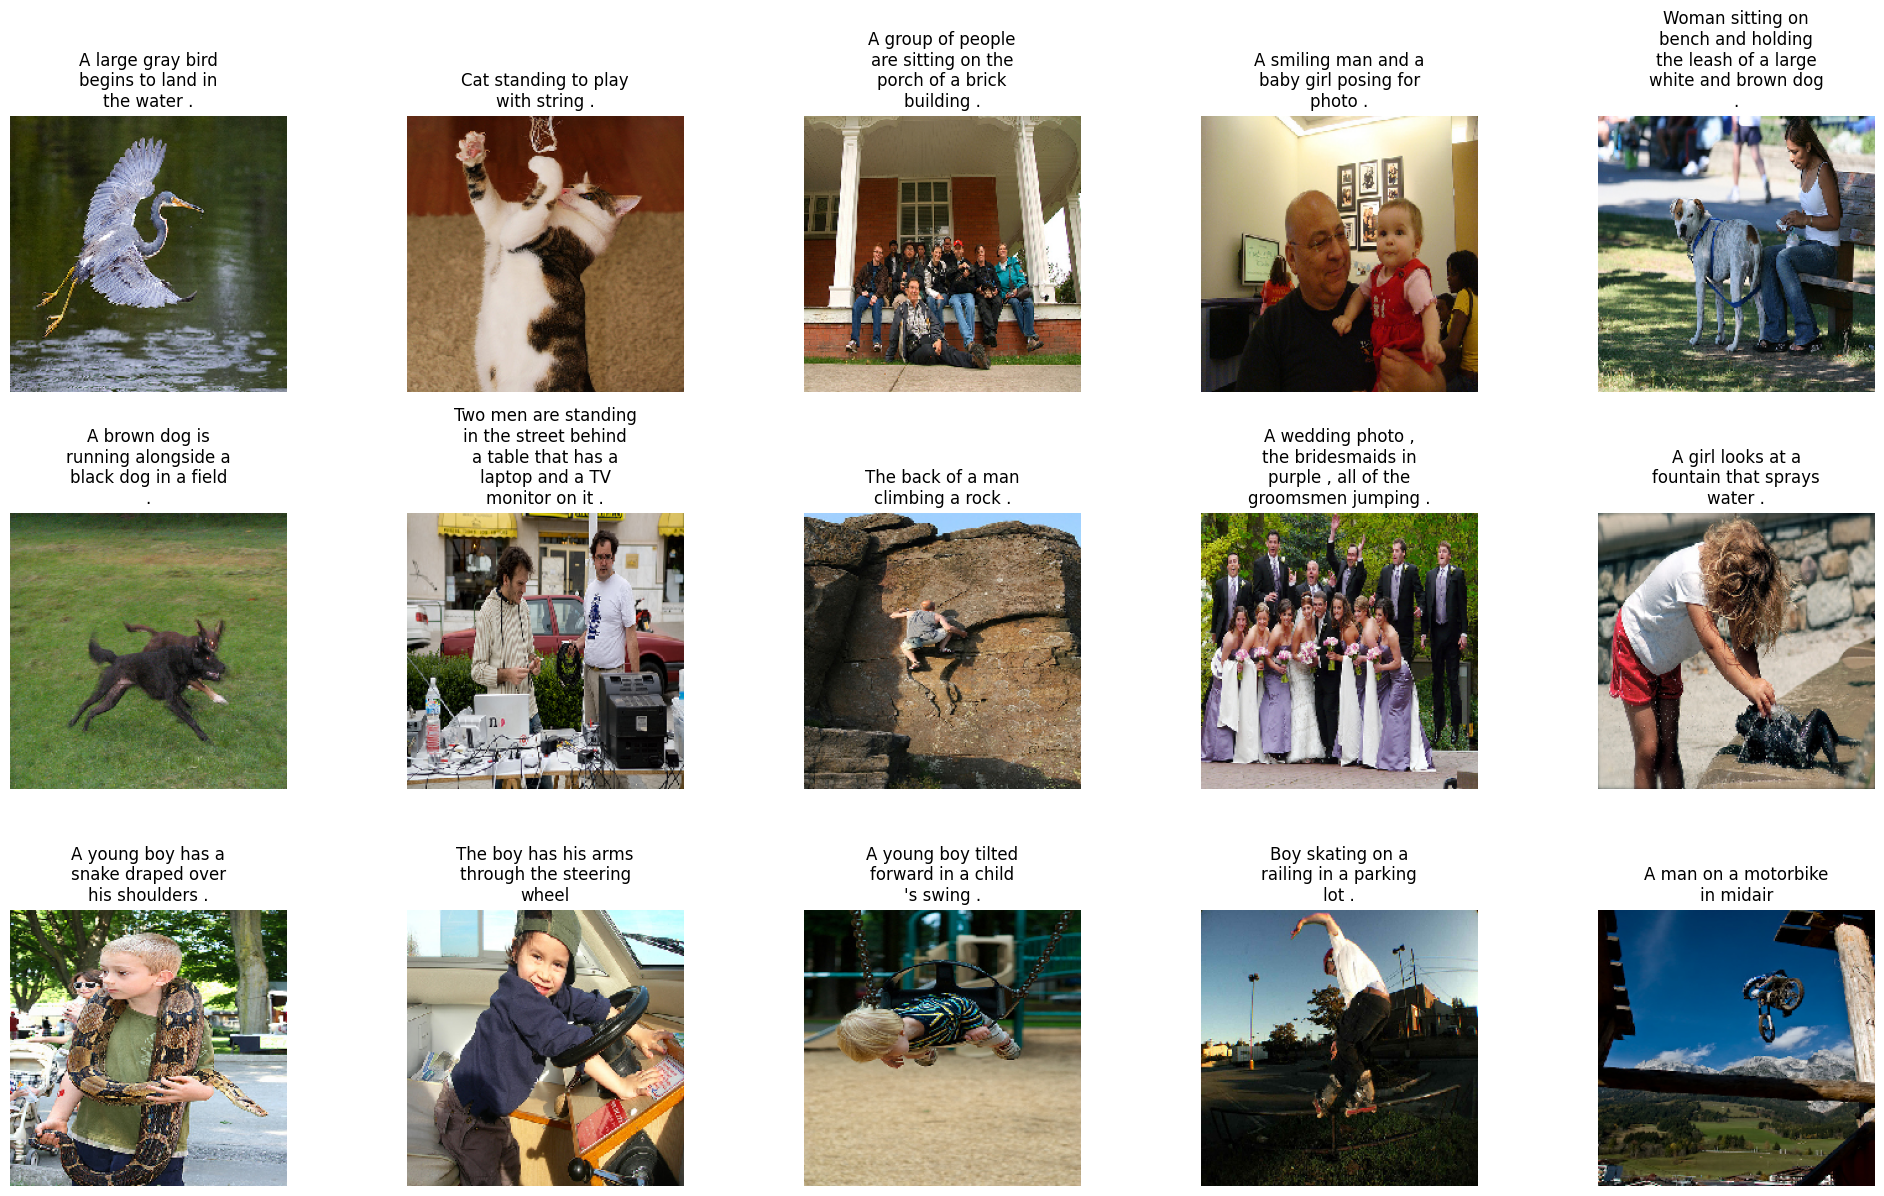

In [6]:
display_images(data.sample(15).reset_index(drop=True))

## Caption text Preprocessing:
### Convert sentences into lowercase
### Remove special characters and numbers present in the text
### Remove extra spaces
### Remove single characters
### Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [7]:
def text_preprocessing(data):
    data['caption']=data['caption'].apply(lambda x: x.lower()) # to lowercase
    data['caption']=data['caption'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', '', x)) ## removing special chars-- Except alphabets, numbers and white space !
    data['caption']=data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) # removingsingle chars
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data 
    
data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Tokenization and Encoded Representation:
#### The words in a sentence are separated/tokenized and encoded in a one hot representation
#### These encodings are then passed to the embeddings layer to generate word embeddings

"A boy plays" → ["A", "boy", "plays"] → [1, 2, 3] → embeddings → [[...], [...], [...]]


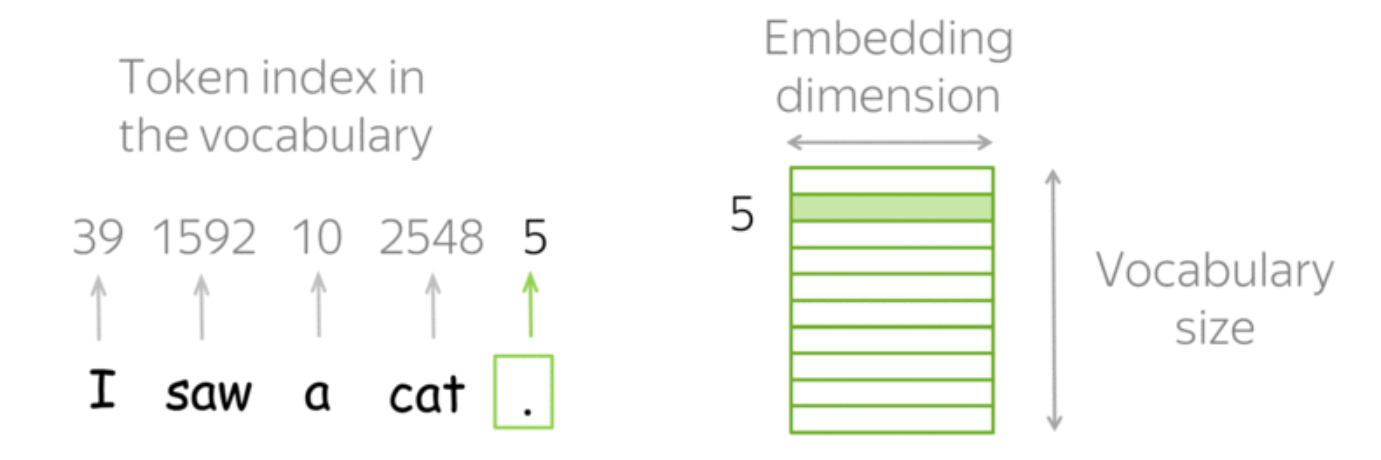

In [8]:
tokenizer = Tokenizer()
# It builds the vocabulary(all words of all captions) and assigns each unique word a unique index.
# Example Vocabulary (word → index):
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1 # word_index is a mapping of word and index

**But Tokenizer() → gives you integer IDs.**

**Embedding() → converts those IDs into smart, learnable vectors (where order of sequence matters so we will use embedding later in mdoelling part in layers !!)**

In [9]:
max_length = max(len(caption.split()) for caption in captions) # this helps in padding sentences later!!! 

In [10]:
# as many captions might share same image -- so will train only unique images!
images = data['image'].unique().tolist() # unique image paths
nimages = len(images)

# Calculates where to split your dataset into training and validation (e.g., 85% train, 15% validation).
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# new dataframes -- train will have only paths which are there in train_images only....
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [11]:
# Testing the tokenizer....!
tokenizer.texts_to_sequences([captions[1]])[0]
# numbers of first caption(index in word->index mapping) !!!!!!!

[1, 18, 312, 63, 192, 116, 2]

### Image Feature Extraction:
DenseNet 201 Architecture is used to extract the features from the images.

Any other pretrained architecture can also be used for extracting features from these images.

Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920.

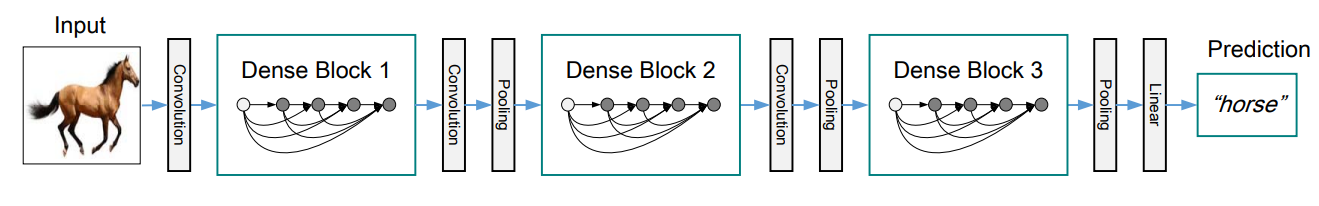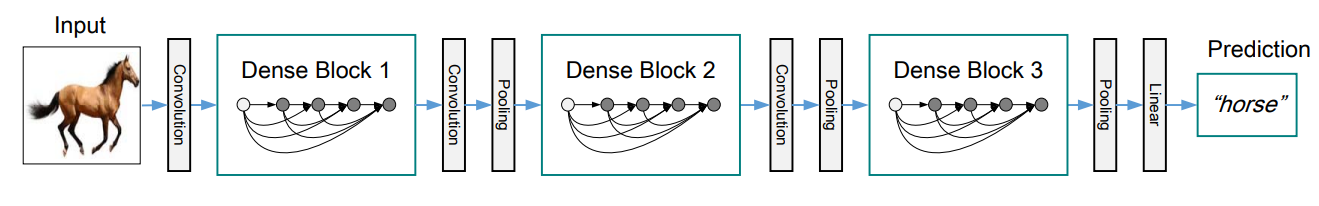

In [12]:
model = DenseNet201() # ---> Full pre trained neural network
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
# We cut off its very last layer(because we just need the weights --> knowledge of images) 
# and keep the 1920‑unit vector(feature map) that describes the image. --- same as include_top=False


img_size = 224
features = {} # we will save feature vectors of each image here !

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img) # we ot feature vector of each image to put in model !
    img = img/255.

    # Keras predict() demands 4‑D shape.
    img = np.expand_dims(img,axis=0) # Adds a new first axis → shape (1,224,224,3).
    
    # Sends the tensor through DenseNet201 (up to its 2nd‑last layer).
    feature = fe.predict(img, verbose=0)
    features[image] = feature

I0000 00:00:1750584764.670419  173014 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1750584777.899131  173103 service.cc:148] XLA service 0x7ce4fc004070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750584777.899178  173103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750584779.931547  173103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750584791.829169  173103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [13:48<00:00,  9.76it/s]


**After this loop-- images will look like this:**

{

  'img1.jpg': array([[0.12, 0.88, …, 0.03]]),      # shape (1,1920)
  
  'img2.jpg': array([[0.07, 0.55, …, 0.21]]),
  
  'img3.jpg': array([[0.44, 0.13, …, 0.67]])
  
}


**These vectors are what the captioning model will receive as the image input.**

## **Data Generation**


Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise.

The inputs will be the image embeddings and their corresonding caption text embeddings for the training process.

The text embeddings are passed word by word for the caption generation during inference time

### **Keras provides a class called Sequence for this purpose — we extend it by writing our own CustomDataGenerator:**

This class must implement 3 things:


def __len__(self):        # → how many batches are there

def __getitem__(self, i): # → return one batch (X, y)

def on_epoch_end(self):  # → optional: shuffle data after each epoch

In [13]:
# This is basically keras template of Sequence--- we are just modifying it according to out project !

# It creates batches of training data.

# And each batch contains:
# X1 → image feature vector (1920 → converted to 256 in model)
# X2 → partial padded caption sequence (like [1, 4, 23, 0, 0])
# y → the next word (like dog, converted to a one-hot vector)

# So our model learns:
# "Given an image + a sentence so far → what's the next word?"

# And for each of these, the same image feature vector (X1) is used.
# So yes — same image is used multiple times, but each time with a longer partial caption.


# Sequence will have: images and their correspinding captions
class CustomDataGenerator(Sequence): # we are extending keras template
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df         = df.copy()                    # dataframe with image+caption rows
        self.X_col      = X_col                        # column name that has image names
        self.y_col      = y_col                        # column name that has captions
        self.directory  = directory                    # folder where images live (not used here – we already pre‑extracted features)
        self.batch_size = batch_size
        self.tokenizer  = tokenizer                    # to turn words -> integers
        self.vocab_size = vocab_size
        self.max_length = max_length                  # longest caption length
        self.features   = features                    # dict:  image_name  ->  CNN feature vector
        self.shuffle    = shuffle
        self.n          = len(self.df)                # total rows

    # If shuffle=True, reshuffles rows each epoch.
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    # how many batches per epoch :
    def __len__(self):
        return self.n // self.batch_size

    # build ONE batch when Keras asks for batch *index*
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y


    # helper that actually converts image+caption rows into arrays
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist() # particular images of 1 whole batch
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


# Each time, this train_gen and valid_gen return a batch of data in this format:
# (X1, X2), y --- > (image,partialCaption, nextWord)
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# **Till here we have two things ready :**

**image_vector – 1920 numbers that DenseNet‑201 gave us. Think of it as
“photo ki condensed summary.”**

**caption_tokens – a list of integers like [2, 45, 98, 0, 0].
Each number = one word ID from your vocabulary.**

But Tokenizer() → gives you integer IDs.

Embedding() → converts those IDs into smart, learnable vectors.


## **Input:**
Image (as a 1920-dimensional vector from DenseNet)

Partial Caption (converted to a sequence of numbers) ---------------->> not full caption-- only partial and keep asking model to predict next word for a particular image 

## **Output:**
→ One-hot encoded next word

## Modelling :

**We are using 1-Many RNN as we have non sequential(image pixel values) input and seq output(text, seq) so we output at every timestep.**


The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network.

The LSTM network starts generating words after each input thus forming a sentence at the end




## Just understand this:

Imagine you have:

🖼️ Image feature vector (extracted by DenseNet201): like a summary of what’s in the image → e.g. [0.1, 0.3, ..., 0.7] of length 1920.

✏️ Partial caption so far like: "startseq a dog" → converted to a sequence of numbers like [2, 45, 98].

Now you feed both into the model → and it predicts the next word, say "is" → then you add it and continue: "startseq a dog is" and repeat until "endseq" is predicted.

## **In short :**

Task: Look at a picture and keep saying one word at a time until a full caption pops out.

Challenge: A photo is a single 1920‑number vector, while a sentence is a time‑series of word IDs.

Solution: Build a network that can drink two inputs at once (image + partial caption), swirl them together, and spit out the next word.

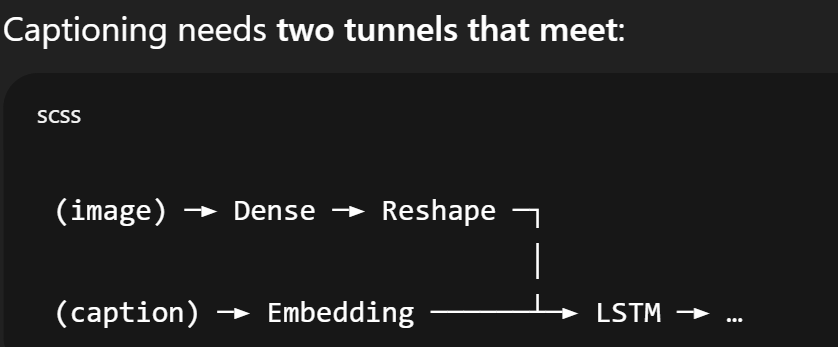

In [ ]:
# can't use tf sequential() as two things are there - image & captions--> 
# the moment you add the image branch and that concatenate + add jump, Sequential() can’t describe it.
# so Keras forces us to use the Functional API (like drawing a small flow‑chart).

from tensorflow.keras.utils import plot_model

# we have two inputs: image and it's caption !!
input1 = Input(shape=(1920,)) #  image feature vector-- 1920 rows
input2 = Input(shape=(max_length,)) # input caption sequence
# A sentence like: "startseq a dog" becomes [2, 45, 98, 0, 0] (padded to max_length, let’s say 5).


## Fully connected layers:

# 1. Handle image feature vectors : Keras Gate1 (Image architecture)
img_features = Dense(1024, activation='relu')(input1) # layer 1- Shrinks the big vector down to 1024 useful numbers
img_features = Dense(512, activation='relu')(img_features)        
img_features = BatchNormalization()(img_features)           # normalize
img_features = Dense(256, activation='relu')(img_features)  # compress to 256
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features) # Turns that 1‑D list into a tiny “sequence” of length 1
# LSTM expects a sequence shape (timesteps, features) (like word1, word2, ...)-- so (1,256)- 1 row- 256 columns


# 2. Handle caption tokens: Keras Gate2 (Captions architecture)
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# 3. Concatenate both of them ( Join image + text into one timeline)
merged = concatenate([img_features_reshaped,sentence_features],axis=1) 
# Resulting shape = (1 + max_length , 256)-- 1 image vector and max_length ka caption and 256 columns(embeddings)

# 4. LSTM Layer finally : Feeding merged sequence into an LSTM-->learn context of image+words
# sentence_features = LSTM(256)(merged)
sentence_features = Bidirectional(LSTM(256, return_sequences=True))(merged)  # full output
sentence_features = LSTM(256)(sentence_features)                                             # final state
sentence_features = Dropout(0.1)(sentence_features)

# Exra layers:
x = Dropout(0.1)(sentence_features) # dropout layer-- avoids overfitting
x = add([x, img_features]) # Skip‑connection: mix original image information again

#neural network:
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Output final layer: Gives probability for every next word using softmax function
output = Dense(vocab_size, activation='softmax')(x)
# we don't know how many classes in final output-- so it depends on vocab_size !! 




#putting both image_vec and partial caption in the model to get a output with a proper 
# loss function to compare with actual arget next word of eac step of each caption
caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# If continously for 10 consecutive epocjs-- there is no reduction in loss then it stops the training midway
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 20, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)



# Training:
# train_generator gives those (X1,X2),y to the model -- means it give every batch to the model to get trained
# for a single caption: for each step of partial caption it gives the next batch

# storing our model in 'history'
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1166 - loss: 5.7193
Epoch 1: val_loss improved from inf to 4.47415, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 88s 149ms/step - accuracy: 0.1167 - loss: 5.7181 - val_accuracy: 0.2142 - val_loss: 4.4741 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2377 - loss: 4.2138
Epoch 2: val_loss improved from 4.47415 to 4.11173, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 145ms/step - accuracy: 0.2377 - loss: 4.2136 - val_accuracy: 0.2576 - val_loss: 4.1117 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2754 - loss: 3.8168
Epoch 3: val_loss improved from 4.11173 to 3.94770, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - accuracy: 0.2754 - loss: 3.8168 - val_accuracy: 0.2811 - val_loss: 3.9477 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.

In [30]:
print(history.history.keys())

dict_keys(['loss', 'val_loss', 'learning_rate'])


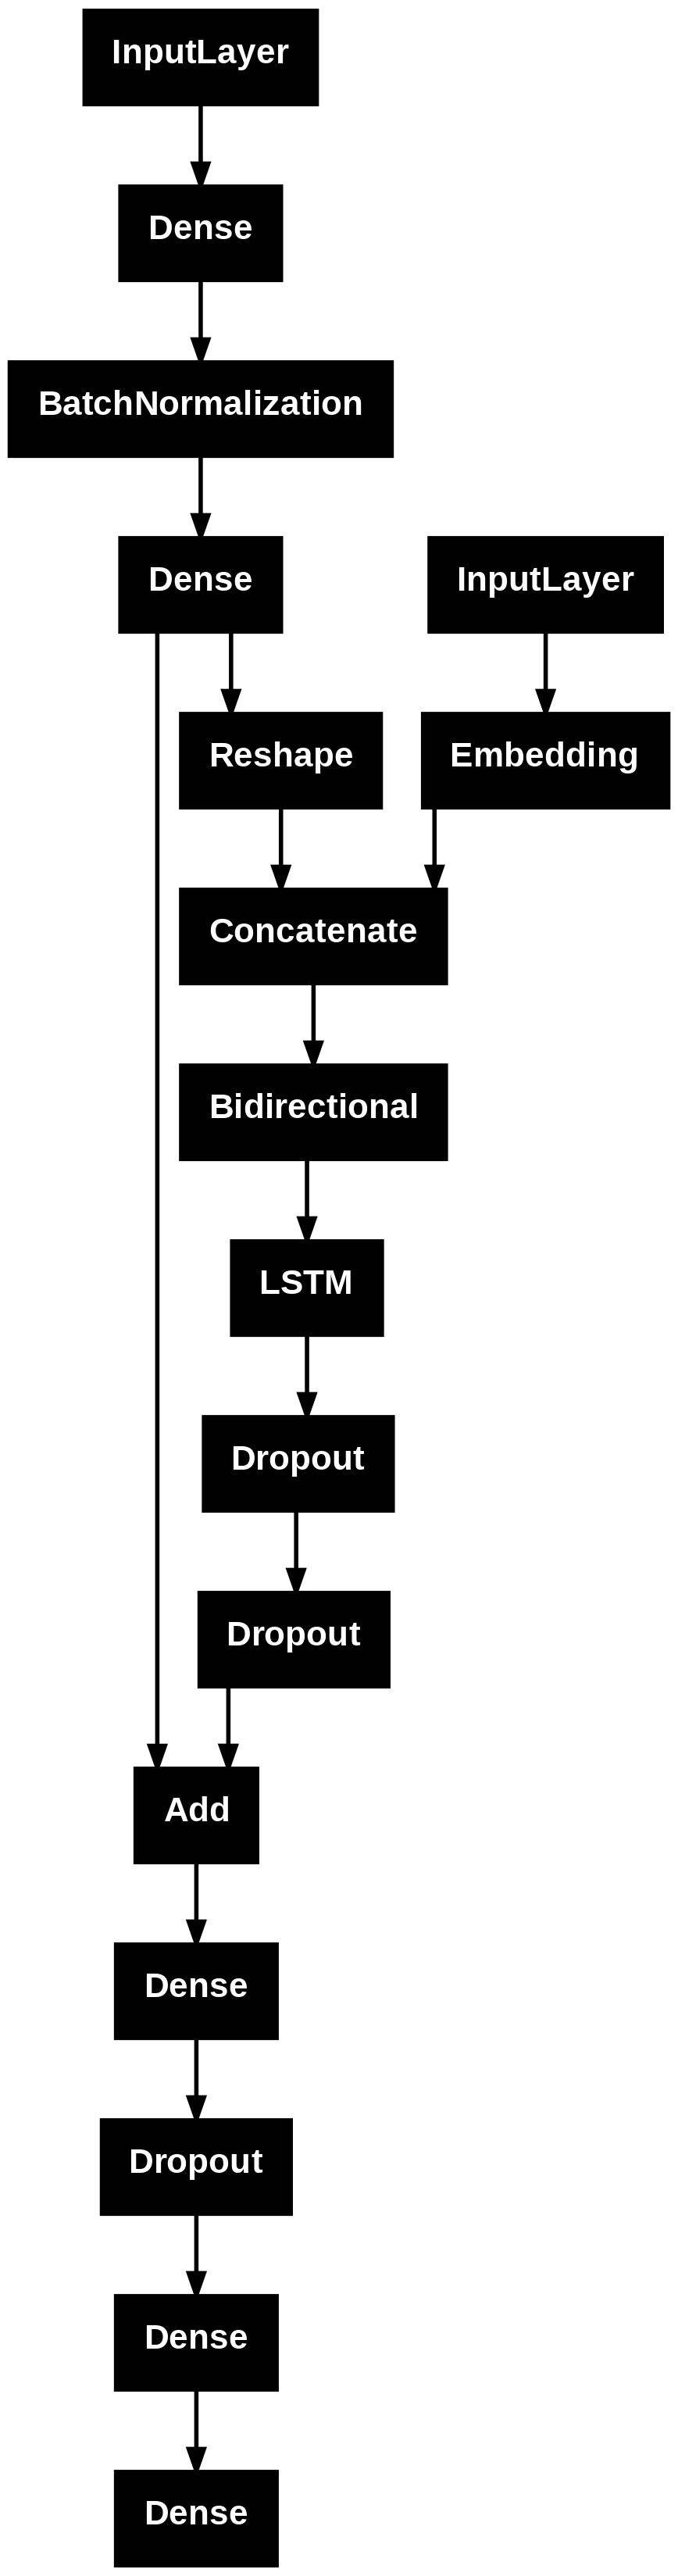

In [31]:
plot_model(caption_model)

## **Now our model is trained-->**
**So now:**

**You give the image**

**You start with "startseq"**

**The model predicts one word at a time, until it says "endseq" or hits max length**

### Learning Curve:

The model has clearly overfit, possibly due to less amount of data.

We can tackle this problem in two ways:

- Train the model on a larger dataset Flickr40k

- Attention Models

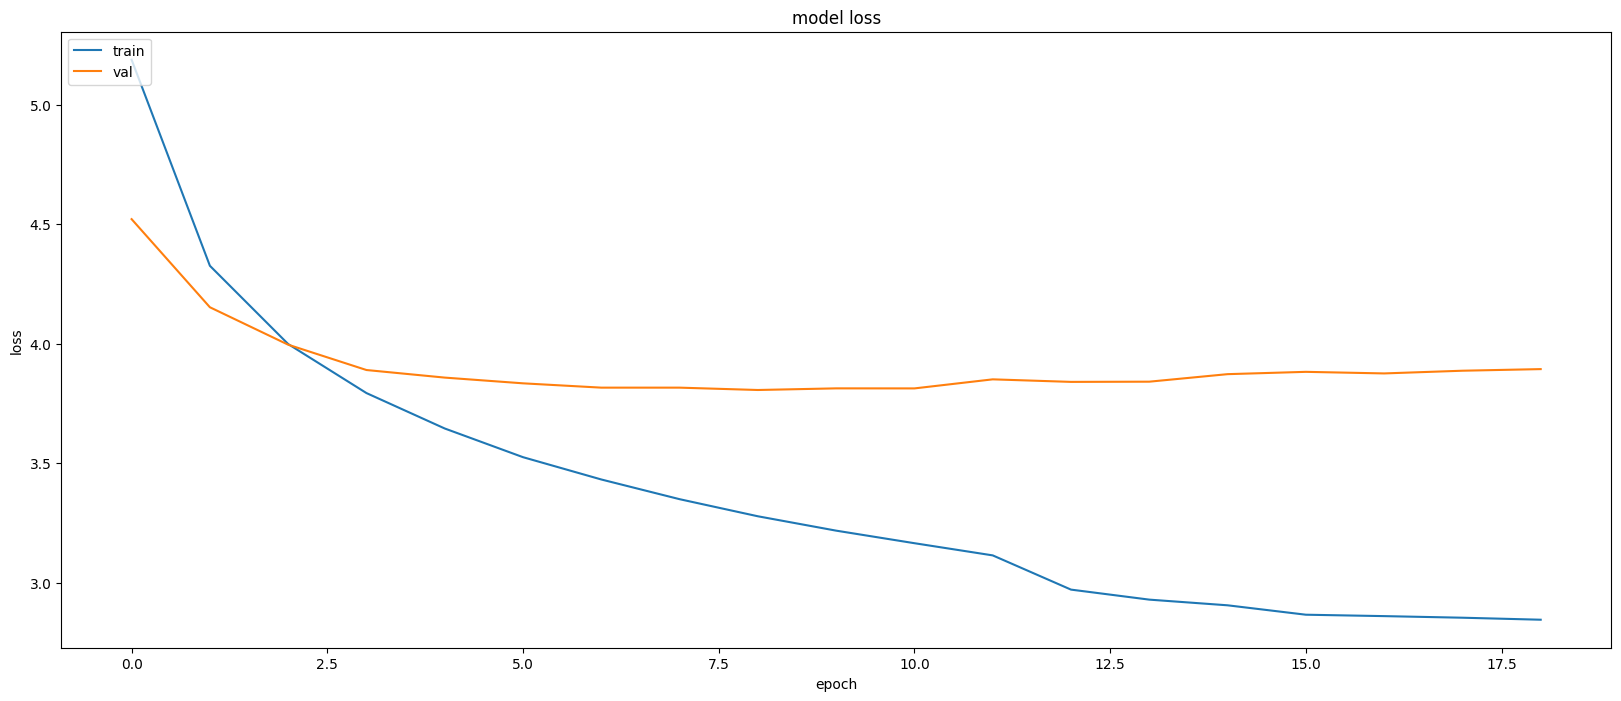

In [16]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Caption Generation Utility Functions
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [17]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features


    # Convert the text so far to numbers
    # Pad it to max_length
    # Predict next word using the model
    # Add that word to the sentence
    # Repeat this...

    
    # Generate the caption:
    in_text = "startseq" # input text to start for a caption-- as our model learned through this only !
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # giving input as (image, start_word):
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

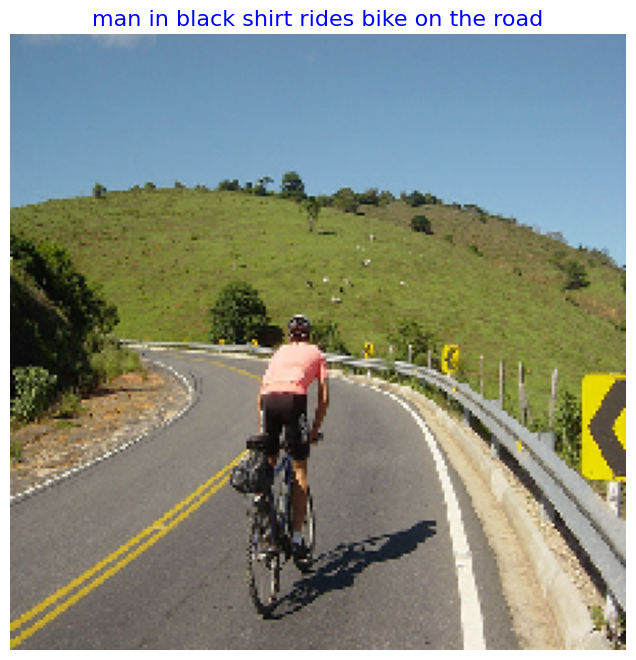

In [19]:
# Example usage
image_path = "/kaggle/input/flickr8k/Images/110595925_f3395c8bd6.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

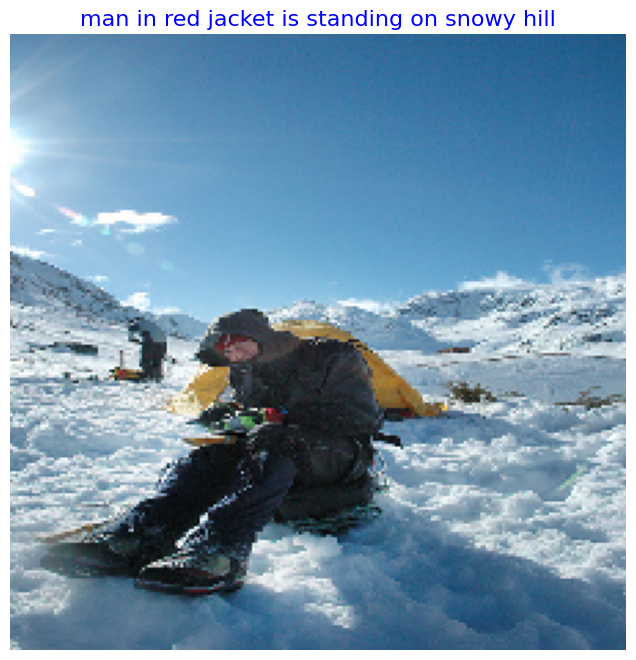

In [20]:
image_path = "/kaggle/input/flickr8k/Images/116409198_0fe0c94f3b.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

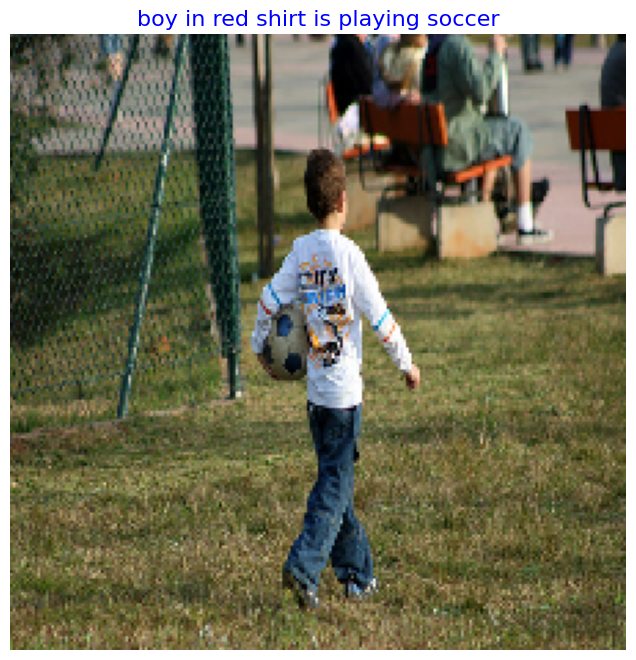

In [44]:
image_path = "/kaggle/input/flickr8k/Images/1104133405_c04a00707f.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
image_path = "/kaggle/input/flickr8k/Images/1089181217_ee1167f7af.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [34]:
# Get indexes where 'soccer' appears in the caption
soccer_indexes = [i for i, caption in enumerate(captions) if 'soccer' in caption.split()]

# Print few matching indexes and their captions
for idx in soccer_indexes[:10]:
    print(f"Index: {idx} → Caption: {captions[idx]}")


Index: 475 → Caption: startseq boy carrying soccer ball endseq
Index: 477 → Caption: startseq boy walks with soccer ball near fence endseq
Index: 478 → Caption: startseq boy wearing white tshirt walks on the grass and carries soccer ball endseq
Index: 479 → Caption: startseq small boy carries soccer ball on field endseq
Index: 650 → Caption: startseq boy dressed in soccer attire and holding his shoes getting out of car endseq
Index: 651 → Caption: startseq boy in red soccer strip is holding his boots in his hand whilst stepping out of car endseq
Index: 653 → Caption: startseq child getting out of the car wearing soccer shoes endseq
Index: 654 → Caption: startseq young boy gets out of the van and prepares his shoes for wear during soccer game endseq
Index: 1045 → Caption: startseq little girl in colorful dress is playing with blue and red soccer ball endseq
Index: 1046 → Caption: startseq little girl in dress playing with soccer ball endseq


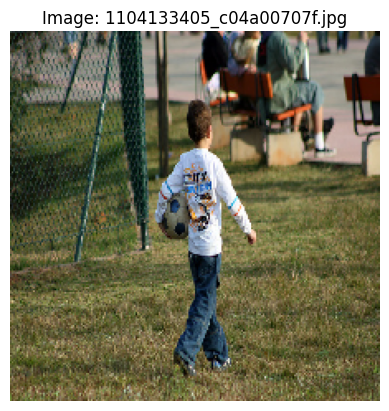

/kaggle/input/flickr8k/Images/1104133405_c04a00707f.jpg


In [43]:
# Step 1: Get the image file name from row 478 in train
first_image_name = train.loc[478, 'image']

# Step 2: Define the folder where images are stored
image_folder = "/kaggle/input/flickr8k/Images"

# Step 3: Construct the full path
image_path = os.path.join(image_folder, first_image_name)

# Step 4: Load and display the image
img = load_img(image_path, target_size=(224, 224))  # Resize if needed
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {first_image_name}")
plt.show()

print(image_path)